<a href="https://colab.research.google.com/github/osmarbraz/Exemplos_BLOOM/blob/main/ExemplosWordEmbeddingContextualBLOOOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exemplo de Desambiguação de palavras usando BLOOM Transformers by HuggingFace

https://huggingface.co/docs/transformers/model_doc/bloom

https://huggingface.co/blog/bloom-megatron-deepspeed

https://huggingface.co/blog/zero-shot-eval-on-the-hub

# **A execução pode ser feita através do menu Ambiente de Execução opção Executar tudo.**

Exemplo de geração de textos emm:
https://huggingface.co/spaces/huggingface/bloom_demo

Exemplos de **Desambiguação de palavras(pt-br)** usando **BLOOM** em sentenças. No final do notebook estão os exemplos com as palavras:

**Link biblioteca Huggingface:**
https://github.com/huggingface/transformers




# 0 - Preparação do ambiente
Preparação do ambiente para execução do exemplo.

## Tratamento de logs

Método para tratamento dos logs.

In [1]:
# Biblioteca de logging
import logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)

## Identificando o ambiente Colab

Cria uma variável para identificar que o notebook está sendo executado no Google Colaboratory.

In [2]:
# Se estiver executando no Google Colaboratory
import sys

# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = "google.colab" in sys.modules

# 1 - Instalação Transformer da Hugging Face

Instala a interface pytorch para o BERT by Hugging Face. 

In [3]:
# Instala a última versão da biblioteca
# !pip install transformers

# Instala uma versão específica da biblioteca
!pip install -U transformers==4.23.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 2 - Carregando o BLOOM

O modelo BLOOM foi proposto com suas várias versões através do BigScience Workshop. A BigScience é inspirada em outras iniciativas de ciência aberta onde os pesquisadores reuniram seu tempo e recursos para alcançar coletivamente um impacto maior. A arquitetura do BLOOM é essencialmente semelhante ao GPT3 (modelo auto-regressivo para previsão do próximo token), mas foi treinado em 46 linguagens diferentes e 13 linguagens de programação. Várias versões menores dos modelos foram treinadas no mesmo conjunto de dados. BLOOM está disponível nas seguintes versões:


Modelos:
 - bigscience-small-testing (32,3 MB) - Ok Colab
 - bloom-560m (1,12 GB) - Ok Colab 
 - bloom-1b1 (2,13 GB) - Ok Colab
 - bloom-1b7 (3,44 GB) - Não carrega no Colab
 - bloom-3b (6,01 GB) - Não carrega no Colab
 - bloom-7b1 (9,98 + 4,16 GB) - Não carrega no Colab
 - bloom (176 Bilhões de parâmetros) (7,19 GB + 44 * 4,93GB)

 Lista dos modelos:
  - https://huggingface.co/models?other=bloom

In [4]:
# modelo_bloom = "bigscience-small-testing"
# modelo_bloom = "bigscience/bloom-560m"
modelo_bloom = "bigscience/bloom-1b1"

# modelo_bloom = "bigscience/bloom-1b7"
# modelo_bloom = "bigscience/bloom-3b"
# modelo_bloom = "bigscience/bloom-7b1"
# modelo_bloom = "bigscience/bloom"

## 2.1 Carrega o tokenizador

In [5]:
from transformers import BloomTokenizerFast

tokenizer = BloomTokenizerFast.from_pretrained(modelo_bloom)

## 2.2 - Carregando o Modelo BLOOM(AutoModelForCausalLM)



In [6]:
from transformers import BloomModel

model = BloomModel.from_pretrained("bigscience/bloom-560m")

# 4 - Funções auxiliares

## Similaridade do cosseno entre os embeddings.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html#scipy.spatial.distance.cosine

A função spatial.distance.cosine do módulo scipy calcula a distância em vez da similaridade do cosseno, mas para conseguir isso, podemos subtrair o valor da distância de 1.

Intervalo de [-1,1] 

Vetores iguais a distância é igual 1.

Vetores diferentes medida próxima de -1.

In [7]:
# Import das bibliotecas.
from scipy.spatial.distance import cosine

def similaridadeCosseno(embeddings1, embeddings2):
    """
      Similaridade do cosseno dos embeddings dos textos.
      
      Parâmetros:
      `embeddings1` - Um embedding a ser medido.
      `embeddings2` - Um embedding a ser medido.
    """
    
    similaridade = 1 - cosine(embeddings1, embeddings2)
    
    return similaridade

## Distância Euclidiana entre os embeddings.

Possui outros nomes como distância L2 ou norma L2.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.euclidean.html#scipy.spatial.distance.euclidean

In [8]:
# Import das bibliotecas.
from scipy.spatial.distance import euclidean

def distanciaEuclidiana(embeddings1, embeddings2):
    """
      Distância euclidiana entre os embeddings dos textos.
      Possui outros nomes como distância L2 ou norma L2.
      
      Parâmetros:
      `embeddings1` - Um embedding a ser medido.
      `embeddings2` - Um embedding a ser medido.
    """
    
    distancia = euclidean(embeddings1, embeddings2)
    
    return distancia

## Distância Manhattan entre os embeddings.

Possui outros nomes como distância Cityblock, distância L1, norma L1 e métrica do táxi.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cityblock.html#scipy.spatial.distance.cityblock

In [9]:
# Import das bibliotecas.
from scipy.spatial.distance import cityblock

def distanciaManhattan(embeddings1, embeddings2):
    """
      Distância Manhattan entre os embeddings dos textos 
      Possui outros nomes como distância Cityblock, distância L1, norma L1 e métrica do táxi.
      
      Parâmetros:
      `embeddings1` - Um embedding a ser medido.
      `embeddings2` - Um embedding a ser medido.
    """
    
    distancia = cityblock(embeddings1, embeddings2)

    return distancia

# 4 - Exemplos com BLOOM

## 4.1 - Exemplo palavra "banco"

O exemplo com a palavra banco foi realizado utilizando a última camada, soma das 4 últimas, concatenação das 4 últimas camadas e a soma de todas as camadas.

#### Inicialização

In [10]:
# Define um sentença de exemplo com diversos significados da palavra  "banco"
documento = "Depois de roubar o cofre do banco,"\
        " o ladrão de banco foi visto " \
        "sentado no banco da praça central."

# Divide a sentença em tokens
input = tokenizer(documento, return_tensors="pt")

# Mostra os tokens com seus índices
i = 0
for tup in zip(input['input_ids'][0], input['attention_mask'][0]):
    # print(tup[0], tup[1])
    print("{:>3} {} {}".format(i, tup[0], tup[1]))
    i= i + 1

  0 56120 1
  1 283 1
  2 172781 1
  3 329 1
  4 246831 1
  5 727 1
  6 39406 1
  7 15 1
  8 329 1
  9 68832 1
 10 631 1
 11 283 1
 12 39406 1
 13 4455 1
 14 21669 1
 15 104405 1
 16 654 1
 17 39406 1
 18 891 1
 19 127597 1
 20 9001 1
 21 17 1


Gera os embeddings para a sentença e retorna a saída em  `outputs`.


In [11]:
import torch

# Prediz os atributos dos estados ocultos para cada camada
with torch.no_grad():    
  
    # Retorno de model quando output_hidden_states=True´ é setado:    
    outputs = model(**input)   

#### Visualizando o intervalo de valores

Recupera a última camada.

In [12]:
# Recupera a última camada oculta da saída
last_hidden_states = outputs.last_hidden_state

print ("O vetor da última camada oculta tem o formato:", last_hidden_states.size())

O vetor da última camada oculta tem o formato: torch.Size([1, 22, 1024])


Plota de valores para o token.

tensor(329) tensor(1)


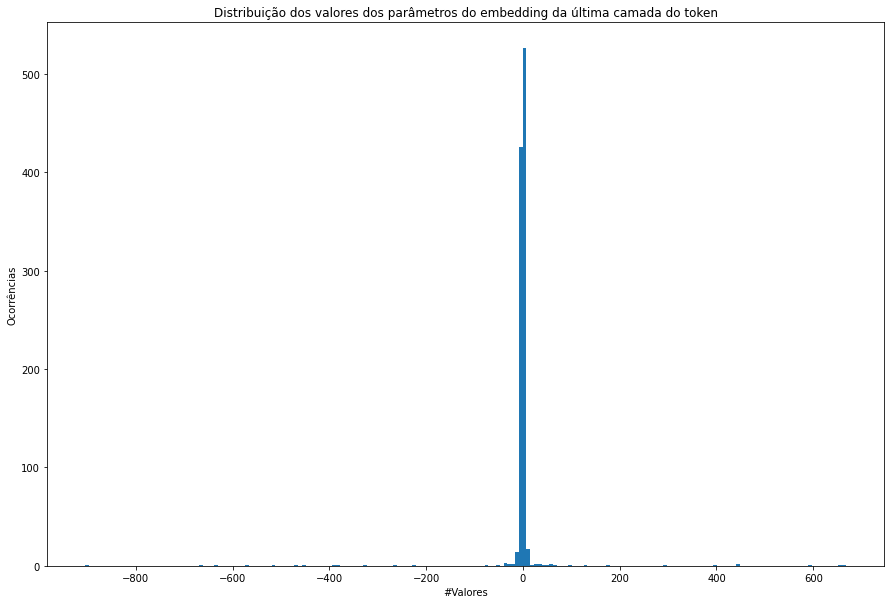

In [13]:
# Import da biblioteca gráfica
import matplotlib.pyplot as plt
%matplotlib inline

# Plota os tokens da sentença
token_i = 8
layer_i = 0

# Recupera o vetor de embeddings da camada para o token
vec = last_hidden_states[layer_i][token_i]

# Mostra a palavra do token_i
print(input['input_ids'][0][token_i], input['attention_mask'][0][token_i])

# Aumenta o tamanho da plotagem do gráfico
plt.figure(figsize=(15,10))

# Título do gráfico
plt.title("Distribuição dos valores dos parâmetros do embedding da última camada do token")
# Documento do eixo x
plt.xlabel("#Valores")
# Documento do eixo y
plt.ylabel("Ocorrências")

# Cria o histograma com 200 classes
plt.hist(vec, bins=200)

# Mostra o gráfico
plt.show()

Vamos nos livrar da dimensão lotes "batches", pois não precisamos dela.

In [14]:
print ("O vetor da última camada oculta tem o formato:", last_hidden_states.size())

# Remove a dimensão 1, o lote "batches".
# O método ´squeeze´ remove a primeira dimensão(0) pois possui tamanho 1
token_embeddings = torch.squeeze(last_hidden_states, dim=0)

print ("O vetor de tokens de embedding da senteça tem o formato:", token_embeddings.size())

O vetor da última camada oculta tem o formato: torch.Size([1, 22, 1024])
O vetor de tokens de embedding da senteça tem o formato: torch.Size([22, 1024])


Confirmando vetores dependentes do documento


In [15]:
for i, ind in enumerate(input['input_ids'][0]):
    print(i, ind, tokenizer.convert_ids_to_tokens(ind.item()))

0 tensor(56120) Depois
1 tensor(283) Ġde
2 tensor(172781) Ġroubar
3 tensor(329) Ġo
4 tensor(246831) Ġcofre
5 tensor(727) Ġdo
6 tensor(39406) Ġbanco
7 tensor(15) ,
8 tensor(329) Ġo
9 tensor(68832) Ġladr
10 tensor(631) Ã£o
11 tensor(283) Ġde
12 tensor(39406) Ġbanco
13 tensor(4455) Ġfoi
14 tensor(21669) Ġvisto
15 tensor(104405) Ġsentado
16 tensor(654) Ġno
17 tensor(39406) Ġbanco
18 tensor(891) Ġda
19 tensor(127597) ĠpraÃ§a
20 tensor(9001) Ġcentral
21 tensor(17) .


Exibe os embenddings das palavras

A banco aparece nos índices 8, 14 e 19.


In [16]:
# Índice das palavras a serem comparadas
palavra1 = 6
palavra2 = 12
palavra3 = 17

print("Os primeiros 5 valores de cada instância de \"banco\".")
print("")
print(tokenizer.convert_ids_to_tokens(input['input_ids'][0][palavra1].item()), str(token_embeddings[palavra1][:5]))
print(tokenizer.convert_ids_to_tokens(input['input_ids'][0][palavra2].item()), str(token_embeddings[palavra2][:5]))
print(tokenizer.convert_ids_to_tokens(input['input_ids'][0][palavra3].item()), str(token_embeddings[palavra3][:5]))

Os primeiros 5 valores de cada instância de "banco".

Ġbanco tensor([-1.2950,  3.6923,  4.6385, -3.9009, -6.2248])
Ġbanco tensor([-0.7759, -2.3267,  0.2547,  0.7532, -7.3450])
Ġbanco tensor([-1.7359, -0.7332, -0.4747, -5.6300, -8.6327])


#### Comparando as palavras das sentenças
Podemos ver que os valores diferem, mas vamos calcular a semelhança de cosseno entre os vetores para fazer uma comparação mais precisa.

In [17]:
print("Período:", documento)
print("Palavra 1 =", palavra1, "=", tokenizer.convert_ids_to_tokens(input['input_ids'][0][palavra1].item()), "(instituição financeira)")
print("Palavra 2 =", palavra2, "=", tokenizer.convert_ids_to_tokens(input['input_ids'][0][palavra2].item()), "(instituição financeira)")
print("Palavra 3 =", palavra3, "=", tokenizer.convert_ids_to_tokens(input['input_ids'][0][palavra3].item()), "(assento)")

# Calcula a similaridade de coseno entre as palavras banco
# Em "ladrão de banco" versus "banco da praça" (diferentes significados).
banco_diferente = similaridadeCosseno(token_embeddings[palavra2], token_embeddings[palavra3])

print("Vetor de similaridade  para diferentes significados(",palavra2,",",palavra3,"):  %.2f" % banco_diferente)

# Calcula a similaridade de coseno entre as palavras banco
# Em "ladrão de banco" versus "cofre do banco" (mesmo significado).
mesmo_banco = similaridadeCosseno(token_embeddings[palavra2], token_embeddings[palavra1])

print("Vetor de similaridade  para mesmo significado(",palavra2,",",palavra1,"):  %.2f" % mesmo_banco)

# Calcula a similaridade de coseno entre as palavras banco
# Em "cofre do banco" versus "banco da praça" (diferente significados).
banco_diferente2 = similaridadeCosseno(token_embeddings[palavra3], token_embeddings[palavra1])

print("Vetor de similaridade  para diferentes significados(",palavra3,",",palavra1,"):  %.2f" % banco_diferente2)

Período: Depois de roubar o cofre do banco, o ladrão de banco foi visto sentado no banco da praça central.
Palavra 1 = 6 = Ġbanco (instituição financeira)
Palavra 2 = 12 = Ġbanco (instituição financeira)
Palavra 3 = 17 = Ġbanco (assento)
Vetor de similaridade  para diferentes significados( 12 , 17 ):  0.99
Vetor de similaridade  para mesmo significado( 12 , 6 ):  1.00
Vetor de similaridade  para diferentes significados( 17 , 6 ):  1.00


#### Visualizando a Sentença

Aqui, queremos mostrar a conexão entre os tokens de uma sentença usando a incorporação do BERT. Plotamos as inserções dos tokens em um subespaço e marcadores finais e finais da sentença.

In [18]:
# Import das bibliotecas
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline

Transforma  o vetor de embendings em um array.

In [19]:
# Transforma tokens embeddings em um array
embeddings = token_embeddings.numpy()

Base selecionada.

In [20]:
# Converte para um array
W = np.array(embeddings)
# Transforma em um array
B = np.array([embeddings[0], embeddings[-1]])
# Inverte B.T
Bi = np.linalg.pinv(B.T)

Projeta os tokens da palavra no subespaço

In [21]:
Wp = np.matmul(Bi,W.T)

Plota o gráfico da sentença

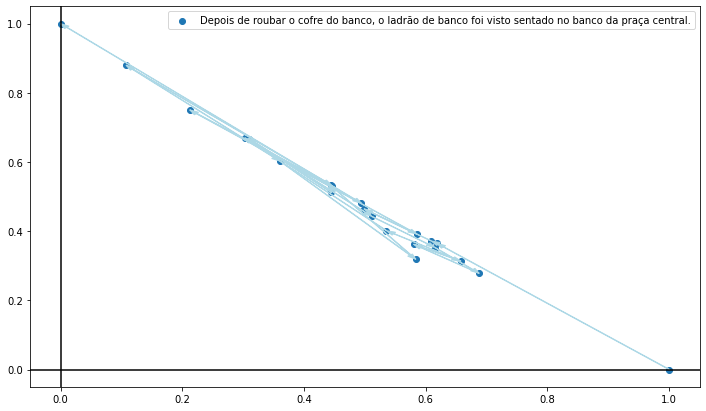

In [22]:
# Aumenta o tamanho da plotagem do gráfico
plt.figure(figsize=(12,7))
plt.axhline(color="black")
plt.axvline(color="black")
plt.scatter(Wp[0,:], Wp[1,:], label=documento)
rX = max(Wp[0,:])-min(Wp[0,:])
rY = max(Wp[1,:])-min(Wp[1,:])
rM = max(rX, rY)
eps = 0.005
for i, ind in enumerate(input['input_ids'][0]):

    token = tokenizer.convert_ids_to_tokens(ind.item())
    # if token in ["[CLS]", "[SEP]"]:
    #     plt.annotate(token, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
    if token == "banco":
        plt.annotate(token, (Wp[0,i]+rX*eps*-6, Wp[1,i]+rX*eps*3))
    if i>0:
        plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color="lightblue", head_length=rM*eps*3, head_width=rM*eps*2, length_includes_head=True)
plt.legend()

# Mostra o gráfico
plt.show()